## Capítulo 12 - Métricas e avaliação de classificação

Será discutido as seguintes métricas e ferramentas  de avaliação neste capítulo: matrizes de confusão, métricas variadas, um relatório de classificação e algumas visualizações. 

Tudo isso será avaliado utilizando um modelo de árvore de decisão que faz a predição de sobrevivência ao Titanic.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from yellowbrick.model_selection import (
    ValidationCurve,
)

In [2]:
# Caminho em Pasta
path = "datasets/titanic/titanic3.xls"
df = pd.read_excel(path)
orig_df = df

In [3]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

#### Matriz de confusão 

Uma matriz de confusão pode ajudar a compreender o desempenho de um classificador. Um classificador binário pode ter quatro resultados de classificação:

    -> TP (True Positives, ou Verdadeiros Positivos);
    
    -> TN (True Negatives, ou Verdadeiros Negativos);
    
    -> FP (False Positives, ou Falso-Positivo);
    
    -> FN (False Negatives, ou Falso-Negativos);
    
   As duas primeiras classificações são corretas.Outra maneira de se lembrar dessas classificações é por meio do fato de que P (para falso-positivo) contém uma única linha vertical (erro do tipo 1), enquanto N (para falso-negativo) contém duas.

###### A seguir, vemos o código pandas para calcular os resultados da classificação. Os comentaários mostram os resultados. Usaremos essas variáveis para calcular outras métricas:

In [4]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [5]:
y_predict = dt.predict(X_test)
tp = (
    (y_test == 1) & (y_test == y_predict)
).sum()  # 123
tn = (
    (y_test == 0) & (y_test == y_predict)
).sum()  # 199
fp = (
    (y_test == 0) & (y_test != y_predict)
).sum()  # 25
fn = (
    (y_test == 1) & (y_test != y_predict)
).sum()  # 46

O ideal é que classificadores bem-comportados tenham contadores elevados na linha diagonal dos verdadeiros. Podemos criar um DataFrame usando a função 'confusion_matrix' do sklearn:

In [6]:
from sklearn.metrics import confusion_matrix
y_predict = dt.predict(X_test)
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=[
        "Predict died",
        "Predict Survive",
    ],
    index=["True Death", "True Survive"],
)

,Predict died,Predict Survive
True Death,199,25
True Survive,48,121


###### O Yellowbrick tem um gráfico para a matriz de confusão.

In [7]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import (
    ConfusionMatrix,
)


/home/luciano/anaconda3/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


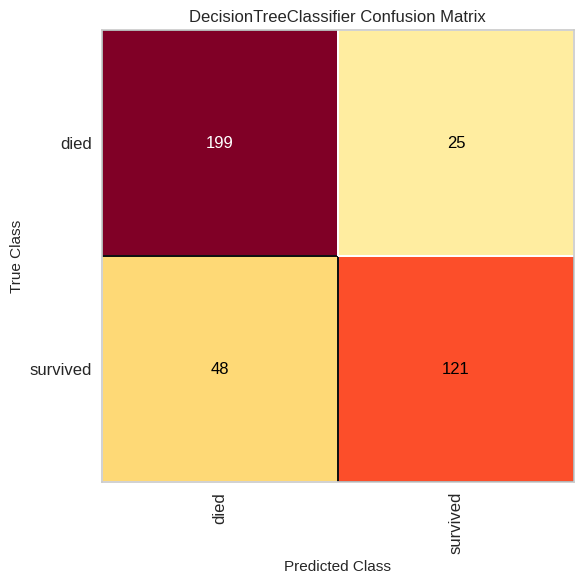

In [8]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    dt, 
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()
fig.savefig("images/mlpr_1202.png", dpi=300)

#### Métricas 

O módulo sklearn.metrics implementa várias métricas muito comuns para classificação, incluindo:

-> 'accuracy' => Percentual de predições corretas.

-> 'average_precision' => Resumo da curva de precisão e recall (revocação).

-> 'f1' => Média harmônica de precisão e recall (revocação).

-> 'neg_log_loss' => Perda logística ou de entropia cruzada (cross-entropy) (o modelo deve aceitar 'predict_proba').

-> 'precision' => Capacidade de encontrar soemnte as amostras relevantes (não atribuir um rótulo positivo ou negativo).

-> 'recall' => Capacidade de encontrar todas as amostras positivas.

-> 'roc_auc' => Área sob a curva ROC (Receiver Operator Characteristic, ou Característica de Operações do Receptor).

Essas strings podem ser usadas no parâmetro 'scoring' em uma busca em grade (frid search), ou pode usar funções do módulo 'sklearn.metrics' com os mesmos nomes das strings, mas que terminem com '_score'.

NOTA:
    
    -> 'f1', 'precision', 'recall' => Aceitam os sufixos a seguir para classificadores com várias classes (multiclass):
        
        -> '_micro' => Média ponderada global da métrica.
        
        -> '_macro' => Média não ponderada da métrica.
        
        -> '_weighted' => Média ponderada pelas várias classes da métrica.
        
        -> '_samples' => Métrica por amostra.

#### Acurácia 

A acurácia (accuracy) é a porcentagem de classificações corretas:


In [9]:
(tp + tn) / (tp + tn + fp + fn)

0.8142493638676844

O que é uma boa acurácia? isso depende. Se estou fazendo a predição de uma fraude (que, em geral, é um evento raro, por exemplo, 1 em 10 mil), poderia ter uma acurácia muito elevada sempre prevendo que não haveria uma fraude. Porém, esse modelo não seria muito útil. Observar outras métricas e o custo de se prever um falso-positivo e um falso-negativo podem nos ajudar a determinar se um modelo é razoável.

###### Podemos usar o sklearn para calcular esse valor para nós:

In [10]:
from sklearn.metrics import accuracy_score
y_predict = dt.predict(X_test)
accuracy_score(y_test, y_predict)

0.8142493638676844

#### Recall 

O recall (revocação) -> Também conhecido como sensibilidade (sensitivity) é a porcentagem de valores positivos classificados corretamente. (Quantos resultados relevantes são devolvidos?)

In [11]:
tp / (tp + fn)

0.7159763313609467

In [12]:
from sklearn.metrics import recall_score
y_predict = dt.predict(X_test)
recall_score(y_test, y_predict)

0.7159763313609467

#### Precisão 

A precisão (precision) é a porcentagem de predições positivas que estavam corretas (TP dividido por (TP + FP)). (Quão relevantes são os resultados?).

In [13]:
tp / (tp + fp)

0.8287671232876712

In [14]:
from sklearn.metrics import precision_score
y_predict = dt.predict(X_test)
precision_score(y_test, y_predict)

0.8287671232876712

#### F1

F1 é a média harmônica de recall (revocação) e precisão:

In [15]:
pre = tp / (tp + fp)
rec = tp / (tp + fn)
(2 * pre * rec) / (pre + rec)

0.7682539682539683

In [16]:
from sklearn.metrics import f1_score
y_predict = dt.predict(X_test)
f1_score(y_test, y_predict)

0.7682539682539683

#### Relatório de classificação

O Yellowbrick tem um relatório de classificação que mostra as pontuações de precisão, recall e f1, para valores tanto positivos como negativos. É um relatório colorido, e, quanto mais vermelha a célula (valor mais próximo de um), melhor será a pontuação.

In [17]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import (
    ClassificationReport,
)

/home/luciano/anaconda3/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


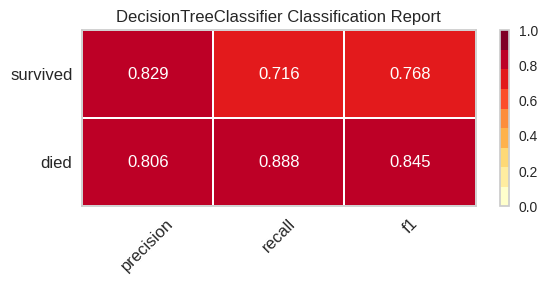

In [18]:
fig. ax = plt.subplots(figsize=(6, 3))
cm_viz = ClassificationReport(
    dt, 
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()
fig.savefig("images/mlpr_1203.png", dpi=300)

#### ROC

A curva ROC mostra o desempenho do classificador, exibindo a taxa de verdadeiros positivos (recall/sensibilidade) à medida que a taxa de falso-positivos (especificidade invertida) muda.

Uma regra geral é que o gráfico deve ter uma protuberância em direção ao canto superior esquerdo. Um traçado que esteja à esquerda e acima de outro sinaliza um desempenho melhor. A diagonal nesse gráfico mostra o comportamento de um classificador com palpites aleatórios. Ao considerar o AUC, terá uma métrica para avaliar o desempenho:

In [19]:
from sklearn.metrics import roc_auc_score
y_predict = dt.predict(X_test)
roc_auc_score(y_test, y_predict)

0.8021845942519018

###### O Yellowbrick é capaz de gerar esse gráfico:

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


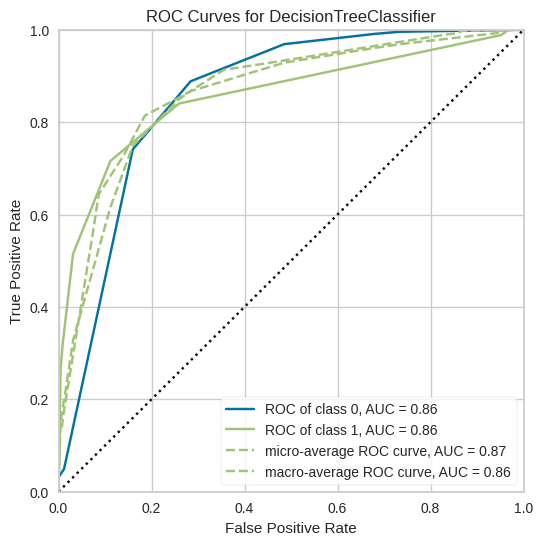

In [20]:
from yellowbrick.classifier import ROCAUC
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(dt)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.poof()
fig.savefig("images/mlpr_1204.png", dpi=300)

#### Curva de precisão-recall

A curva ROC pode ser otimista demais para classes desbalanceadas. Outra opção para avaliar classificadoras é a curva de precisão-recall

Uma classificação é uma tarefa de balanceamento de modo a encontrar tudo de que precisa (recall), ao mesmo tempo que limita os resultados ruins (precisão). Em geral, há um compromisso: 

###### À medida que o recall aumenta, a precisão diminui - e vice-versa.

In [21]:
from sklearn.metrics import (
    average_precision_score,
)

y_predict = dt.predict(X_test)
average_precision_score(y_test, y_predict)

0.7155150490642249

###### Eis o gráfico de uma curva de precisão-recall gerada com o Yellowbrick:

0.8177126373723866


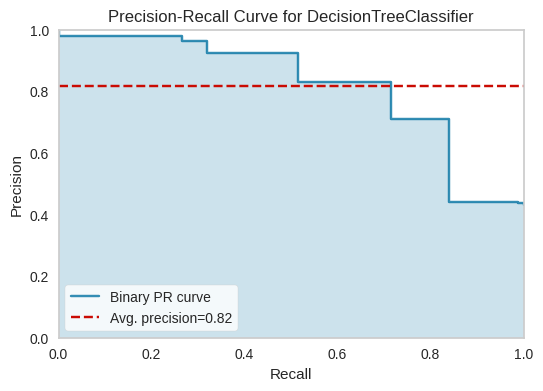

In [22]:
from yellowbrick.classifier import (
    PrecisionRecallCurve,
)

fig, ax = plt.subplots(figsize=(6, 4))
viz = PrecisionRecallCurve(
    DecisionTreeClassifier(max_depth=3)
)
viz.fit(X_train, y_train)
print(viz.score(X_test, y_test))
viz.poof()
fig.savefig("images/mlpr_1205.png", dpi=300)

#### Gráfico de ganhos cumulativos

Um gráfico de ganhos cumulativos (cumulative gains) pode ser usado para avaliar um classificador binário. Esse gráfico modela a taxa de verdadeiros positivos (sensibilidade) em relação à taxa de suporte (fração das predições positivas). A intuição por trás desse gráfico está em ordenar todas as classificações de acordo com a probabilidade prevista. O ideal é que houvesse uma separação clara das predições dividindo as amostras positivas das negativas. Se os primeiros 10% das predições tiverem 30% das amostras positivas, teríamos um ponto de (0,0) a (0,1,0,3). Continuaria esse processo por todas as amostras.

###### A biblioteca scikit-plot (https://oreil.ly/dg0iQ) é capaz de gerar um gráfico de ganhos cumulativos:

In [23]:
#!pip install scikit-plot

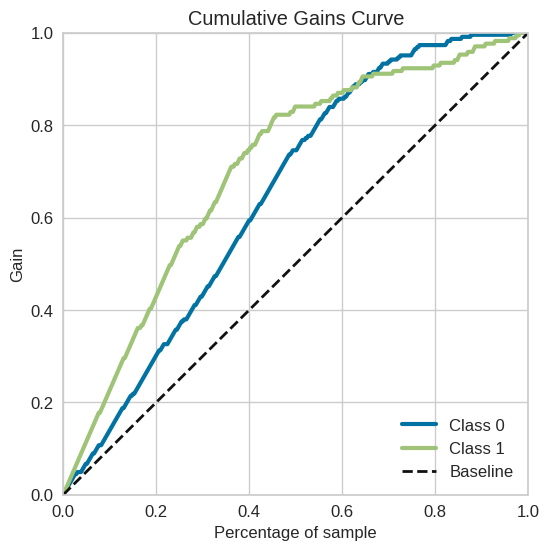

In [24]:
import scikitplot as skplt
fig, ax=plt.subplots(figsize=(6, 6))
y_probas = dt.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(
    y_test, y_probas, ax=ax
)
fig.savefig(
    "images/mlpr_1206.png",
    dpi=300,
    bbox_inches="tight",
)

#### Gráfico de elevação

Um gráfico de elevação (lift curve) é uma outra forma de olhar a informação que está em um gráfico de ganhos acumulativos. A elevação (lift) mostra quão melhor é nosso desempenho em relação ao modelo de base. 

Em nosso gráfico a seguir, podemos ver que, se ordenássemos os passageiros do Titanic de acordo com a probabilidade de sobrevivência e considerásssemos os primeiros 20% , nossa elevação seria de aproximadamente 2,2 vezes (o ganho dividido pela porcentagem de amostra) de melhoria em comparação com escolher sobreviventes de modo aleatório (teríamos 2,2 mais sobreviventes).

###### A biblioteca scikit-plot é capaz de gerar um gráfico de elevação:

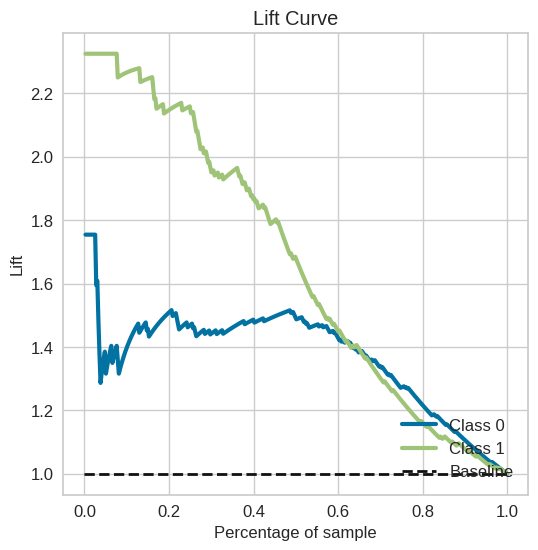

In [25]:
import scikitplot as skplt
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = dt.predict_proba(X_test)
skplt.metrics.plot_lift_curve(
    y_test, y_probas, ax=ax
)
fig.savefig(
    "images/mlpr_1207.png",
    dpi=300,
    bbox_inches="tight",
)

#### Balanceamento das classes

O Yellowbrick tem um gráfico de barras simples para visualizar os tamanhos das classes. Quando os tamanhos relativos das classes são diferentes, a acurácia não é uma boa métrica de avaliação

Ao separar os dados em conjuntos de treinamento e de teste, utilize uma amostragem estratificada, de modo que os conjuntos manteham uma proporção relativa das classes. (A função test_train_split faz isso se definir o parâmetro 'stratify' com os rótulos).

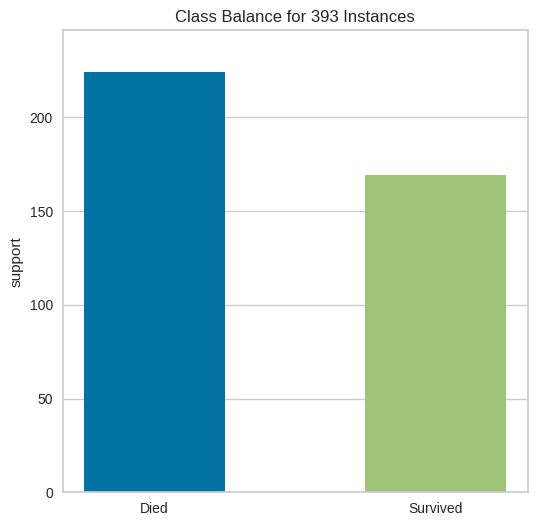

In [26]:
from yellowbrick.classifier import ClassBalance
fig, ax = plt.subplots(figsize=(6, 6))
cb_viz = ClassBalance(
    labels=["Died", "Survived"]
)

cb_viz.fit(y_test)
cb_viz.poof()
fig.savefig("images/mlpr_1208.png", dpi=300)

#### Erro de predição da classe

O gráfico de erro de predição de classe do Yellowbrick é um gráfico de barras que exibe uma matriz de confusão

/home/luciano/anaconda3/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


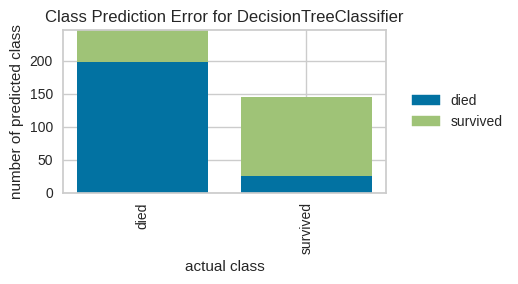

In [27]:
from yellowbrick.classifier import (
    ClassPredictionError,
)

fig, ax = plt.subplots(figsize=(6, 3))
cpe_viz = ClassPredictionError(
    dt,
    classes=["died", "survived"]
)

cpe_viz.score(X_test, y_test)
cpe_viz.poof()
fig.savefig("images/mlpr_1209.png", dpi=300)

#### Limiar de discriminação

A maioria dos classficadores binários que fazem a predição de probabilidades tem um limiar de discriminação  (discrimination thresold) de 50%. Se a probabilidade prevista estiver acima de 50%, o classificador atribuirá um rótulo positivo. Varia esse valor de limiar entre 0 e 100 e mostra o impacto na precisão no recall (revocação), entre f1 e na taxa de fila (queue rate).

Esse gráfico pode ser conveniente para visualizar à relação de compromisso entre precisão e recall.

O Yellowbrick disponibiliza esse visualizador. Ele embaralha ps dados e executa 50 tentativas por padrão, separando 10% para validação.

/home/luciano/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


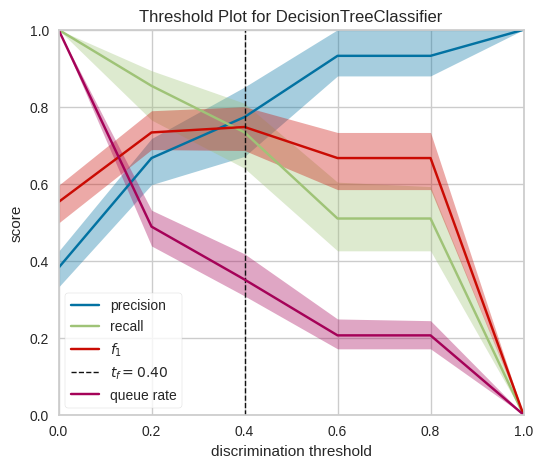

In [29]:
from yellowbrick.classifier import (
    DiscriminationThreshold,
)
fig, ax = plt.subplots(figsize=(6, 5))
dt_viz = DiscriminationThreshold(dt)
dt_viz.fit(X, y)
dt_viz.poof()
fig.savefig("images/mlpr_1210.png", dpi=300)